#  Transaction Fraud Detection

### Problem Statement

Fraud detection is an important aspect of banking and financial companies. It’s essential for both financial institutions as well as their customers to be able to identify fraud quickly and accurately. objective is to build a predictive model to determine whether a given transaction will be fraudulent or not. 

In [1]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score,accuracy_score,classification_report

###  Loading Files and Data

In [2]:
location='transactions.txt'

In [3]:
def create_and_load_data(path):
    dic = {}
    file = open(path, 'r')
    for line in file:
        ser = json.loads(line)
        for i in ser.keys():
            if i not in dic.keys():
                dic[i] = []
            dic[i].append(ser[i])
    return dic

In [4]:
data = create_and_load_data(location)

In [5]:
df = pd.DataFrame(data)

In [6]:
df.to_csv('transaction.csv')
#for future use 

In [7]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [8]:
df_copy = df.copy()

In [9]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

###  Data Cleaning

In [10]:
df_copy['transactionDate'] = df_copy['transactionDateTime'].apply(lambda x : x.split('T')[0])
df_copy['transactionTime'] = df_copy['transactionDateTime'].apply(lambda x : x.split('T')[1])
df_copy['merchantName'] = df_copy['merchantName'].apply(lambda x : x.split('#')[0])
df_copy['currentExpMonth'] = df_copy['currentExpDate'].apply(lambda x : x.split('/')[0])
df_copy['currentExpYear'] = df_copy['currentExpDate'].apply(lambda x : x.split('/')[1])
df_copy['accountOpenMonth'] = df_copy['accountOpenDate'].apply(lambda x : x.split('-')[1])
df_copy['accountOpenYear'] = df_copy['accountOpenDate'].apply(lambda x : x.split('-')[0])
df_copy['accountOpenDate'] = df_copy['accountOpenDate'].apply(lambda x : x.split('-')[2])
df_copy['MonthOfLastAddressChange'] = df_copy['dateOfLastAddressChange'].apply(lambda x : x.split('-')[1])
df_copy['YearOfLastAddressChange'] = df_copy['dateOfLastAddressChange'].apply(lambda x : x.split('-')[0])
df_copy['DateOfLastAddressChange'] = df_copy['dateOfLastAddressChange'].apply(lambda x : x.split('-')[2])
df_copy['transactionMonth'] = df_copy['transactionDate'].apply(lambda x : x.split('-')[1])
df_copy['transactionDate'] = df_copy['transactionDate'].apply(lambda x : x.split('-')[2])
df_copy['transactionHour'] = df_copy['transactionTime'].apply(lambda x : x.split(':')[0])

In [11]:
df_copy.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,transactionTime,currentExpMonth,currentExpYear,accountOpenMonth,accountOpenYear,MonthOfLastAddressChange,YearOfLastAddressChange,DateOfLastAddressChange,transactionMonth,transactionHour
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,14:27:32,06,2023,03,2015,03,2015,14,08,14
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC,US,US,09,...,05:05:54,02,2024,03,2015,03,2015,14,10,05
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,09:18:39,08,2025,03,2015,03,2015,14,11,09
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,02:14:50,08,2025,03,2015,03,2015,14,12,02
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons,US,US,02,...,21:04:46,10,2029,08,2015,08,2015,06,03,21


In [12]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 40 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [13]:
df_copy.isnull().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
transactionDate             0
transactionTime             0
currentExpMonth             0
currentExpYear              0
accountOpe

In [14]:
(df_copy.customerId == df_copy.accountNumber).all()

True

In [15]:
df_copy.drop(['customerId',
              'transactionTime',
              'transactionDate',
              'dateOfLastAddressChange',
              'accountOpenDate',
              'currentExpDate',
              'transactionDateTime',
              'echoBuffer',
              'merchantCity',
              'merchantState',
              'merchantZip',
              'posOnPremises',
              'recurringAuthInd'],
             axis=1,inplace = True)

In [16]:
df_copy.replace('',np.nan,inplace=True)

In [17]:
df_copy.isnull().sum()

accountNumber                  0
creditLimit                    0
availableMoney                 0
transactionAmount              0
merchantName                   0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
currentExpMonth                0
currentExpYear                 0
accountOpenMonth               0
accountOpenYear                0
MonthOfLastAddressChange       0
YearOfLastAddressChange        0
DateOfLastAddressChange        0
transactionMonth               0
transactionHour                0
dtype: int64

In [18]:
for i in df_copy.columns[df_copy.dtypes == object]:
    df_copy[i] = df_copy[i].str.strip()

In [19]:
#assigning each features with appropriate data type
df_copy = df_copy.astype({'accountNumber':'float',
                          'creditLimit':'float',
                          'availableMoney':'float',
                          'transactionAmount':'float',
                          'merchantName':'object',
                          'acqCountry':'object',
                          'merchantCountryCode':'object',
                          'posEntryMode':'float',
                          'posConditionCode':'float',
                          'merchantCategoryCode':'object',
                          'cardCVV':'float',
                          'enteredCVV':'float',
                          'cardLast4Digits':'float',
                          'transactionType':'object',
                          'currentBalance':'float',
                          'cardPresent':'object',
                          'expirationDateKeyInMatch':'object',
                          'isFraud':'object',
                          'currentExpMonth':'float',
                          'currentExpYear':'float',
                          'accountOpenMonth':'float',
                          'accountOpenYear':'float',
                          'MonthOfLastAddressChange':'float',
                          'YearOfLastAddressChange':'float',
                          'DateOfLastAddressChange':'float',
                          'transactionMonth':'float',
                          'transactionHour':'float'
                         }).astype({'accountNumber':'Int32',
                                    'posEntryMode':'Int32',
                                    'posConditionCode':'Int32',
                                    'cardCVV':'Int32',
                                    'enteredCVV':'Int32',
                                    'cardLast4Digits':'Int32',
                                    'currentExpMonth':'Int32',
                                    'currentExpYear':'Int32',
                                    'accountOpenMonth':'Int32',
                                    'accountOpenYear':'Int32','MonthOfLastAddressChange':'Int32',
                                    'YearOfLastAddressChange':'Int32',
                                    'DateOfLastAddressChange':'Int32',
                                    'transactionMonth':'Int32',
                                    'transactionHour':'Int32'})

In [20]:
df_copy.dtypes

accountNumber                 Int32
creditLimit                 float64
availableMoney              float64
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                  Int32
posConditionCode              Int32
merchantCategoryCode         object
cardCVV                       Int32
enteredCVV                    Int32
cardLast4Digits               Int32
transactionType              object
currentBalance              float64
cardPresent                  object
expirationDateKeyInMatch     object
isFraud                      object
currentExpMonth               Int32
currentExpYear                Int32
accountOpenMonth              Int32
accountOpenYear               Int32
MonthOfLastAddressChange      Int32
YearOfLastAddressChange       Int32
DateOfLastAddressChange       Int32
transactionMonth              Int32
transactionHour               Int32
dtype: object

In [21]:
df_copy.describe(include='all')

,accountNumber,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,isFraud,currentExpMonth,currentExpYear,accountOpenMonth,accountOpenYear,MonthOfLastAddressChange,YearOfLastAddressChange,DateOfLastAddressChange,transactionMonth,transactionHour
count,7.863630e+05,786363.000000,786363.000000,786363.000000,786363,781801,785639,782309.000000,785954.000000,786363,...,786363,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
unique,NaN,NaN,NaN,NaN,205,4,4,NaN,NaN,19,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,AMC,US,US,NaN,NaN,online_retail,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,37942,774709,778511,NaN,NaN,202156,...,773946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.372326e+08,10759.464459,6250.725369,136.985791,NaN,NaN,NaN,9.049943,3.271980,NaN,...,NaN,6.446471,2026.282087,7.043133,2013.548618,6.286028,2014.804087,15.476674,6.648343,11.511333
std,2.554211e+08,11636.174890,8880.783989,147.725569,NaN,NaN,NaN,16.774130,9.809023,NaN,...,NaN,3.446706,3.958592,3.378144,1.872314,3.373176,1.881635,8.591262,3.436256,6.921098
min,1.000881e+08,250.000000,-1005.630000,0.000000,NaN,NaN,NaN,2.000000,1.000000,NaN,...,NaN,1.000000,2019.000000,1.000000,1989.000000,1.000000,1989.000000,1.000000,1.000000,0.000000
25%,3.301333e+08,5000.000000,1077.420000,33.650000,NaN,NaN,NaN,2.000000,1.000000,NaN,...,NaN,3.000000,2023.000000,4.000000,2013.000000,3.000000,2014.000000,8.000000,4.000000,6.000000
50%,5.074561e+08,7500.000000,3184.860000,87.900000,NaN,NaN,NaN,5.000000,1.000000,NaN,...,NaN,6.000000,2026.000000,7.000000,2014.000000,6.000000,2016.000000,15.000000,7.000000,12.000000
75%,7.676200e+08,15000.000000,7500.000000,191.480000,NaN,NaN,NaN,9.000000,1.000000,NaN,...,NaN,9.000000,2030.000000,10.000000,2015.000000,9.000000,2016.000000,23.000000,10.000000,18.000000


##  Visualization

In [22]:
mask = df_copy.dtypes == object
numerical_column = list(df_copy.columns[~ mask])
categorical_column = list(df_copy.columns[mask])

In [23]:
df_copy['isFraud'] = df_copy['isFraud'].replace([True,False],[1,0])

In [24]:
feature_columns = df_copy.corr(method='spearman')['isFraud'].abs().sort_values(ascending=False)>0.005
feature_columns = list(feature_columns.index[feature_columns])

In [25]:
n_i=SimpleImputer(strategy='mean')
c_i=SimpleImputer(strategy='constant',fill_value='Unknown')

df_copy[numerical_column] = n_i.fit_transform(df_copy[numerical_column])
df_copy[categorical_column] = c_i.fit_transform(df_copy[categorical_column])

In [26]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
calc_vif(df_copy[feature_columns].iloc[:,:-1])

,variables,VIF
0,isFraud,1.022315
1,transactionAmount,1.873426
2,posEntryMode,1.292687
3,accountOpenMonth,5.358872
4,enteredCVV,668.764316
5,cardCVV,669.438198
6,currentBalance,1.501609
7,YearOfLastAddressChange,15.234312
8,posConditionCode,1.111404
9,transactionMonth,4.762966


This data frame shows that enterdCVV and cardCVV canbe predicted with other features, and same for YearOfLastAddressChange.

This shows multicollinearity between variables

In [27]:
feature_columns.remove('isFraud')
feature_columns.remove('cardCVV')
feature_columns.remove('YearOfLastAddressChange')

In [28]:
calc_vif(df_copy[feature_columns].iloc[:,:-1])

,variables,VIF
0,transactionAmount,1.745895
1,posEntryMode,1.267599
2,accountOpenMonth,3.747410
3,enteredCVV,3.780841
4,currentBalance,1.488647
5,posConditionCode,1.102986
6,transactionMonth,3.581297


In [29]:
df_copy['isFraud'] = df_copy['isFraud'].replace([1,0],[True,False])

###  Categorical column

In [30]:
categorical_column

['merchantName',
 'acqCountry',
 'merchantCountryCode',
 'merchantCategoryCode',
 'transactionType',
 'cardPresent',
 'expirationDateKeyInMatch',
 'isFraud']

In [31]:
pd.DataFrame(df_copy.groupby([categorical_column[0]])['isFraud']
             .value_counts()).rename(columns={'isFraud':'count'}).reset_index().sort_values(['isFraud','count'],ascending=False)

,merchantName,isFraud,count
178,Lyft,True,760
353,ebay.com,True,639
145,Fresh Flowers,True,553
289,Uber,True,512
115,EZ Putt Putt,True,490
...,...,...,...
282,TMobile Wireless,False,66
304,Verizon Wireless,False,45
28,ATT,False,44
111,Duane Reed,False,28


there are more frauds in Lyft than anyone else in the list and minimum for My Fitness

In [32]:
pd.DataFrame(df_copy.groupby([categorical_column[1]])['isFraud']
             .value_counts()).rename(columns={'isFraud':'count'}).reset_index().sort_values(['isFraud','count'],ascending=False)

,acqCountry,isFraud,count
7,US,True,12122
9,Unknown,True,149
3,MEX,True,64
1,CAN,True,55
5,PR,True,27
6,US,False,762587
8,Unknown,False,4413
2,MEX,False,3066
0,CAN,False,2369
4,PR,False,1511


<AxesSubplot:xlabel='acqCountry', ylabel='count'>

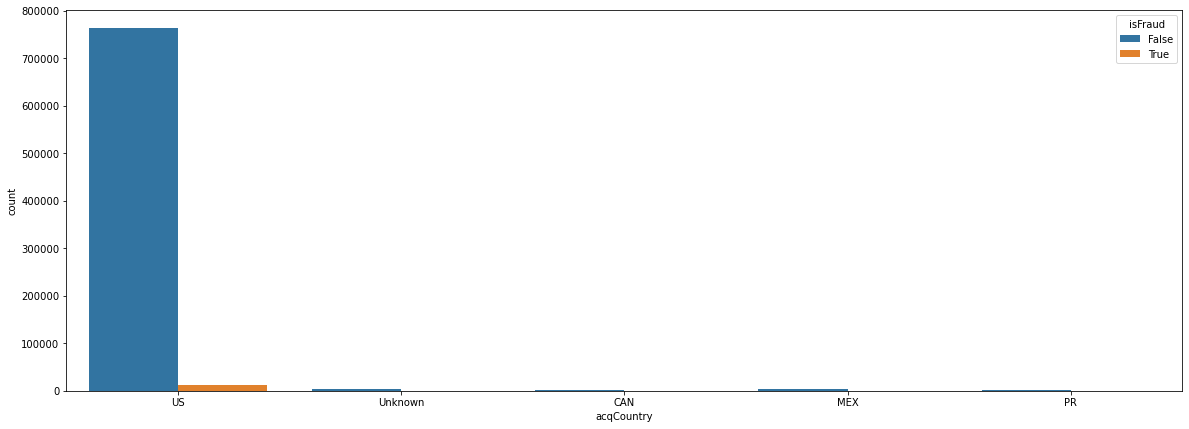

In [33]:
plt.figure(figsize=(20,7))
sns.countplot(data=df_copy,x=categorical_column[1],hue = 'isFraud')

clearly we can see US have fraud rate of 1.5% while for PR the rate is 1.7%. but we can see there are more transcation for US.

In [34]:
pd.DataFrame(df_copy.groupby([categorical_column[2]])['isFraud']
             .value_counts()).rename(columns={'isFraud':'count'}).reset_index().sort_values(['isFraud','count'],ascending=False)

,merchantCountryCode,isFraud,count
7,US,True,12188
9,Unknown,True,82
3,MEX,True,64
1,CAN,True,56
5,PR,True,27
6,US,False,766323
2,MEX,False,3079
0,CAN,False,2370
4,PR,False,1532
8,Unknown,False,642


<AxesSubplot:xlabel='merchantCountryCode', ylabel='count'>

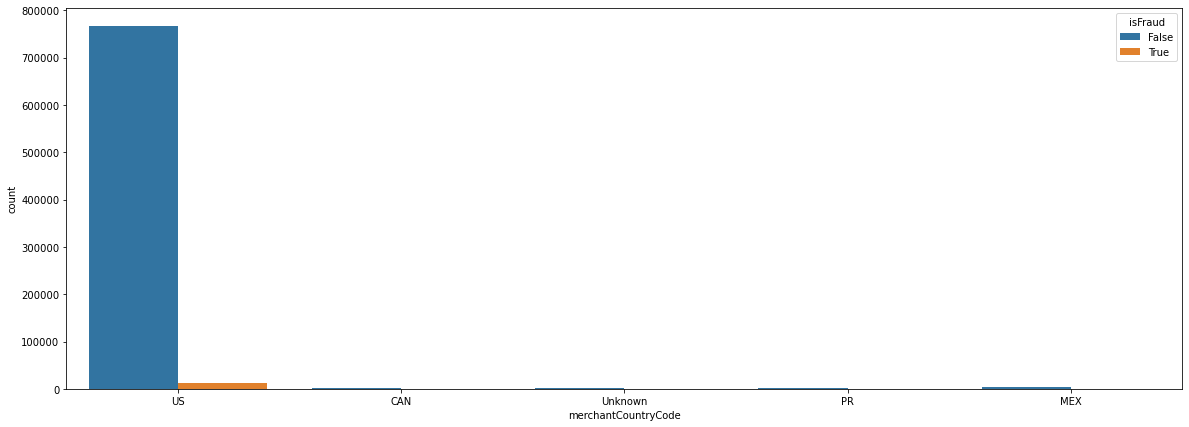

In [35]:
plt.figure(figsize=(20,7))
sns.countplot(data=df_copy,x=categorical_column[2],hue = 'isFraud')

we can note that US have merchant face fraud at the rate of 1.5% which is higher than any other country in the table.

In [36]:
pd.DataFrame(df_copy.groupby([categorical_column[3]])['isFraud']
             .value_counts()).rename(columns={'isFraud':'count'}).reset_index().sort_values(['isFraud','count'],ascending=False)

,merchantCategoryCode,isFraud,count
24,online_retail,True,4938
22,online_gifts,True,1606
29,rideshare,True,1272
8,fastfood,True,1074
10,food,True,1014
6,entertainment,True,961
1,airline,True,534
3,auto,True,273
19,hotels,True,250
31,subscriptions,True,216


<AxesSubplot:xlabel='merchantCategoryCode', ylabel='count'>

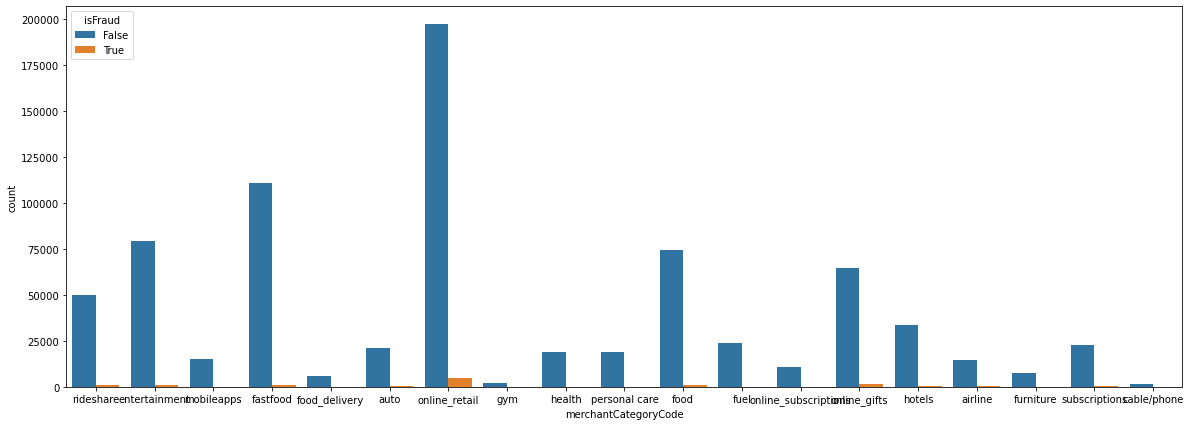

In [37]:
plt.figure(figsize=(20,7))
sns.countplot(data=df_copy,x=categorical_column[3],hue = 'isFraud')

online retail faced have most frauds any many categories didn't even face a single fraud

In [38]:
pd.DataFrame(df_copy.groupby([categorical_column[4]])['isFraud']
             .value_counts()).rename(columns={'isFraud':'count'}).reset_index().sort_values(['isFraud','count'],ascending=False)

,transactionType,isFraud,count
3,PURCHASE,True,11950
5,REVERSAL,True,337
1,ADDRESS_VERIFICATION,True,116
7,Unknown,True,14
2,PURCHASE,False,733243
0,ADDRESS_VERIFICATION,False,20053
4,REVERSAL,False,19966
6,Unknown,False,684


<AxesSubplot:xlabel='transactionType', ylabel='count'>

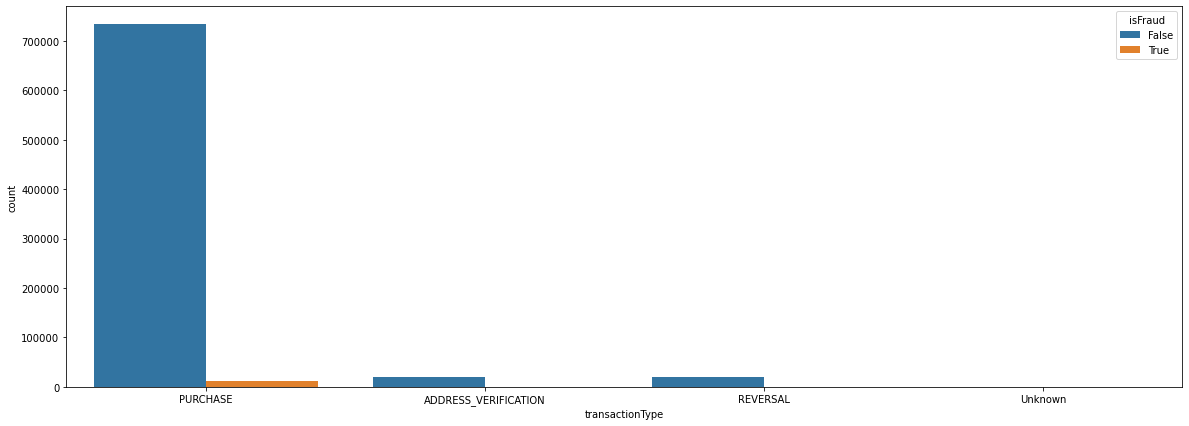

In [39]:
plt.figure(figsize=(20,7))
sns.countplot(data=df_copy,x=categorical_column[4],hue = 'isFraud')

The transaction of kind PURCHASE have faced many frauds while ADDRESS_VERIFICATION have least number of frauds. 

In [40]:
pd.DataFrame(df_copy.groupby([categorical_column[5]])['isFraud']
             .value_counts()).rename(columns={'isFraud':'count'}).reset_index().sort_values(['isFraud','count'],ascending=False)

,cardPresent,isFraud,count
1,False,True,8962
3,True,True,3455
0,False,False,424533
2,True,False,349413


<AxesSubplot:xlabel='cardPresent', ylabel='count'>

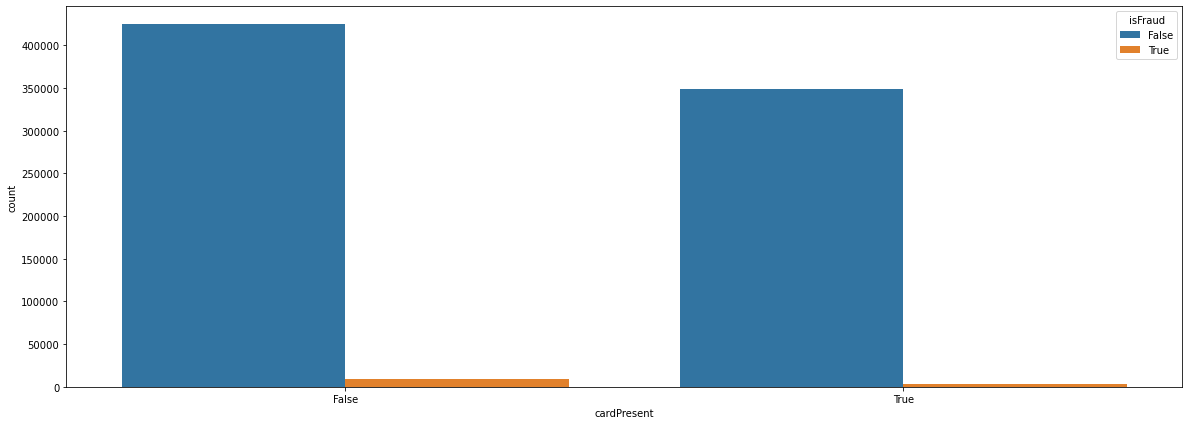

In [41]:
plt.figure(figsize=(20,7))
sns.countplot(data=df_copy,x=categorical_column[5],hue = 'isFraud')

We can see if the card not present the fraud rate is 2%  and when the card is present the fraud rate drops down to 0.9%

In [42]:
pd.DataFrame(df_copy.groupby([categorical_column[6]])['isFraud']
             .value_counts()).rename(columns={'isFraud':'count'}).reset_index().sort_values(['isFraud','count'],ascending=False)

,expirationDateKeyInMatch,isFraud,count
1,False,True,12404
3,True,True,13
0,False,False,772916
2,True,False,1030


<AxesSubplot:xlabel='expirationDateKeyInMatch', ylabel='count'>

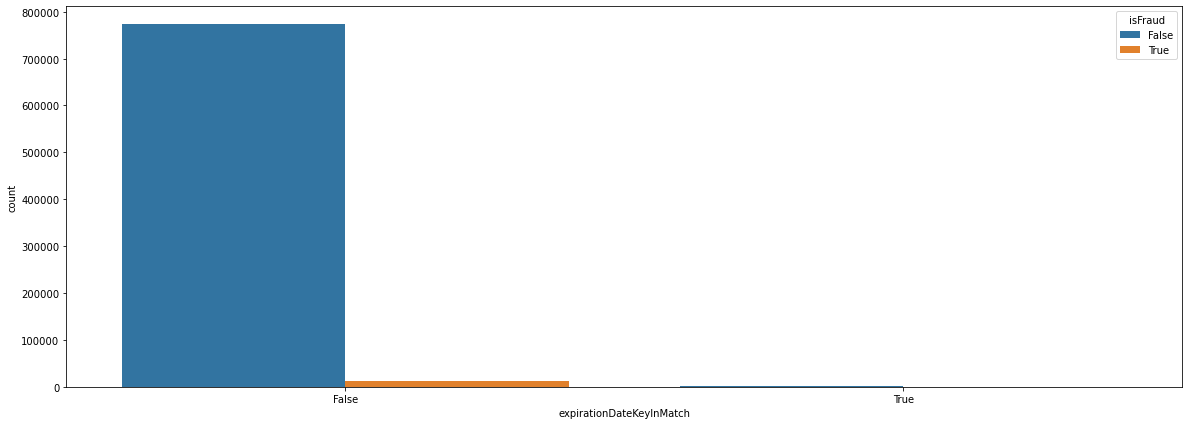

In [43]:
plt.figure(figsize=(20,7))
sns.countplot(data=df_copy,x=categorical_column[6],hue = 'isFraud')

we can see the rate of fraud when expirationDateKeyInMatch is False is 1.5% while the rate of fraud when expirationDateKeyInMatch is True is 1.2%. We can see the drop is of 0.3%, assuming this a significantl small drop we drop this column.

In [44]:
categorical_column.remove('expirationDateKeyInMatch')
categorical_column.remove('isFraud')

### Numerical Column

In [45]:
numerical_column

['accountNumber',
 'creditLimit',
 'availableMoney',
 'transactionAmount',
 'posEntryMode',
 'posConditionCode',
 'cardCVV',
 'enteredCVV',
 'cardLast4Digits',
 'currentBalance',
 'currentExpMonth',
 'currentExpYear',
 'accountOpenMonth',
 'accountOpenYear',
 'MonthOfLastAddressChange',
 'YearOfLastAddressChange',
 'DateOfLastAddressChange',
 'transactionMonth',
 'transactionHour']

In [46]:
true = df_copy[df_copy['isFraud'] == True]
false = df_copy[df_copy['isFraud'] == False]

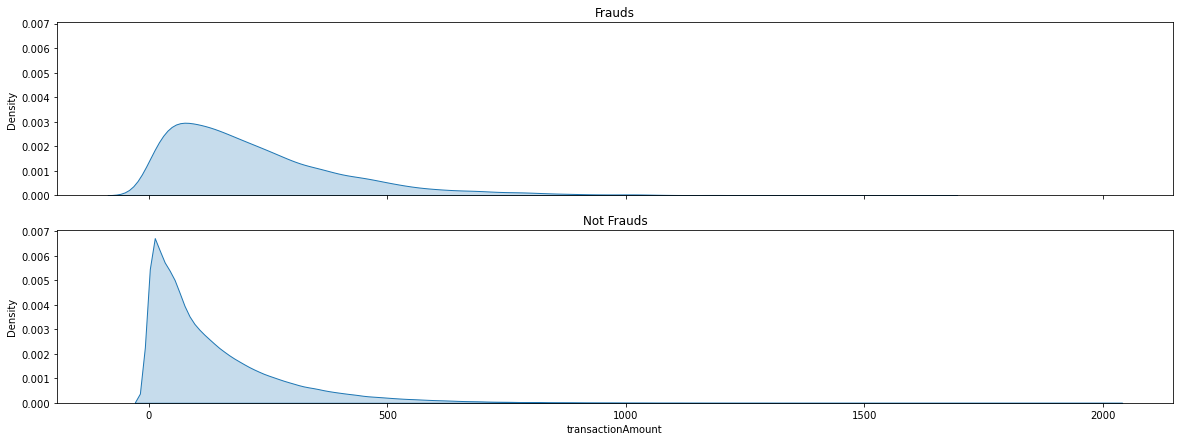

In [47]:
fig,ax = plt.subplots(2,1,sharex=True,sharey=True)
fig.set_figwidth(20)
fig.set_figheight(7)
sns.kdeplot(data = true, x = feature_columns[0],ax=ax[0],shade='fill',thresh=0.5)
ax[0].title.set_text('Frauds')
sns.kdeplot(data = false, x = feature_columns[0],ax=ax[1],shade='fill',thresh=0.5)
ax[1].title.set_text('Not Frauds')

Most of the Non frauds transcations are low values but varies to a long range >2000 whereas as most frauds are low valued, we can also observe that as the peak of Non frauds started to decrease the frauds reaches to its peak.

So we can say the Frauds are done on mid range prices


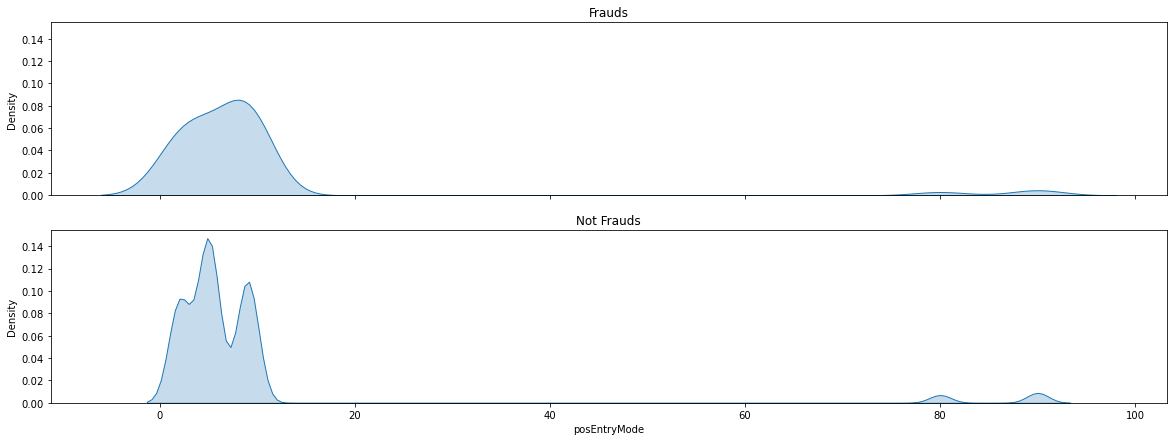

In [48]:
fig,ax = plt.subplots(2,1,sharex=True,sharey=True)
fig.set_figwidth(20)
fig.set_figheight(7)
sns.kdeplot(data = true, x = feature_columns[1],ax=ax[0],shade='fill',thresh=0.5)
ax[0].title.set_text('Frauds')
sns.kdeplot(data = false, x = feature_columns[1],ax=ax[1],shade='fill',thresh=0.5)
ax[1].title.set_text('Not Frauds')

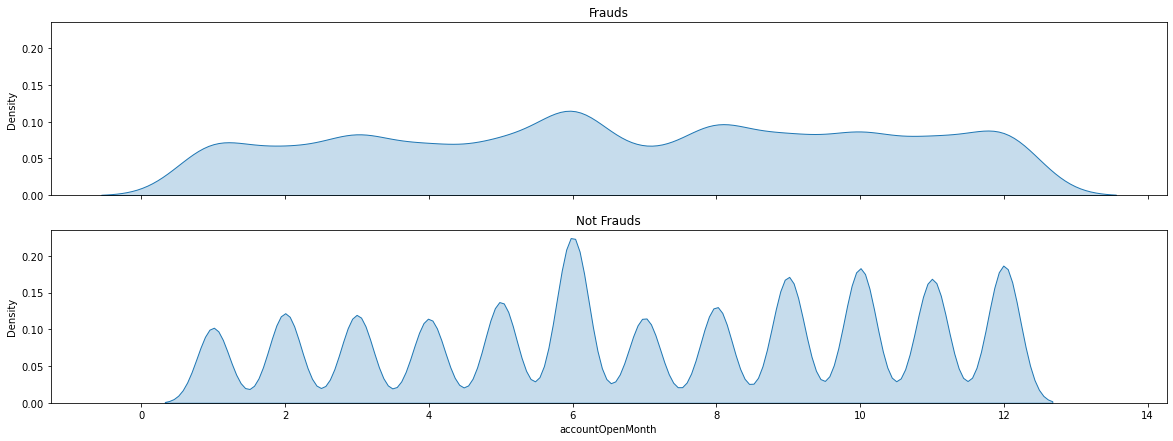

In [49]:
fig,ax = plt.subplots(2,1,sharex=True,sharey=True)
fig.set_figwidth(20)
fig.set_figheight(7)
sns.kdeplot(data = true, x = feature_columns[2],ax=ax[0],shade='fill',thresh=0.5)
ax[0].title.set_text('Frauds')
sns.kdeplot(data = false, x = feature_columns[2],ax=ax[1],shade='fill',thresh=0.5)
ax[1].title.set_text('Not Frauds')

we can see the number of account Open in Different months is nearly same for most of the months, but we can see of the month 6 as the number of account increase the rate of fraud accoutn also increase and for the month 7 the fraud accounts decrease sharply.

So we can say number of frauds are alos depends on the months with large correlation, because as the the number of accounts open increase the frauds also increases.

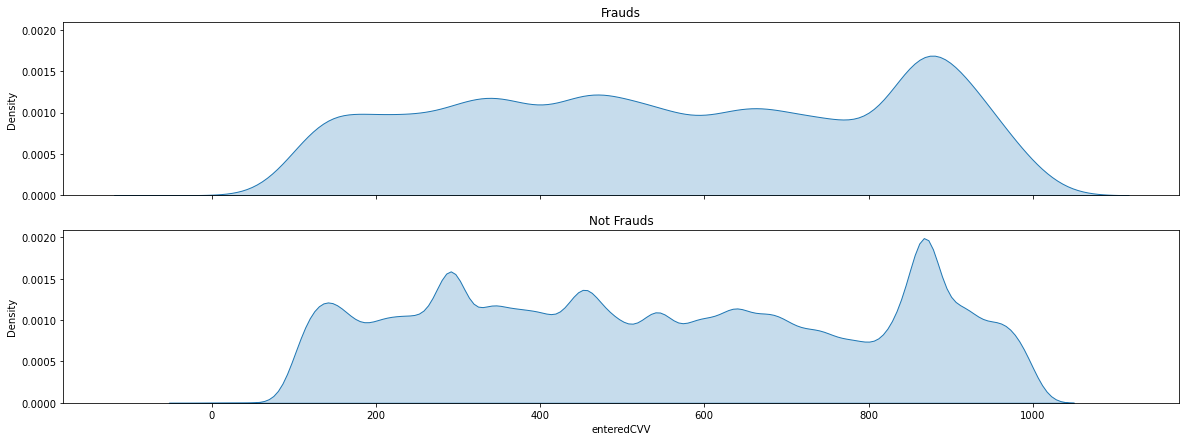

In [50]:
fig,ax = plt.subplots(2,1,sharex=True,sharey=True)
fig.set_figwidth(20)
fig.set_figheight(7)
sns.kdeplot(data = true, x = feature_columns[3],ax=ax[0],shade='fill',thresh=0.5)
ax[0].title.set_text('Frauds')
sns.kdeplot(data = false, x = feature_columns[3],ax=ax[1],shade='fill',thresh=0.5)
ax[1].title.set_text('Not Frauds')

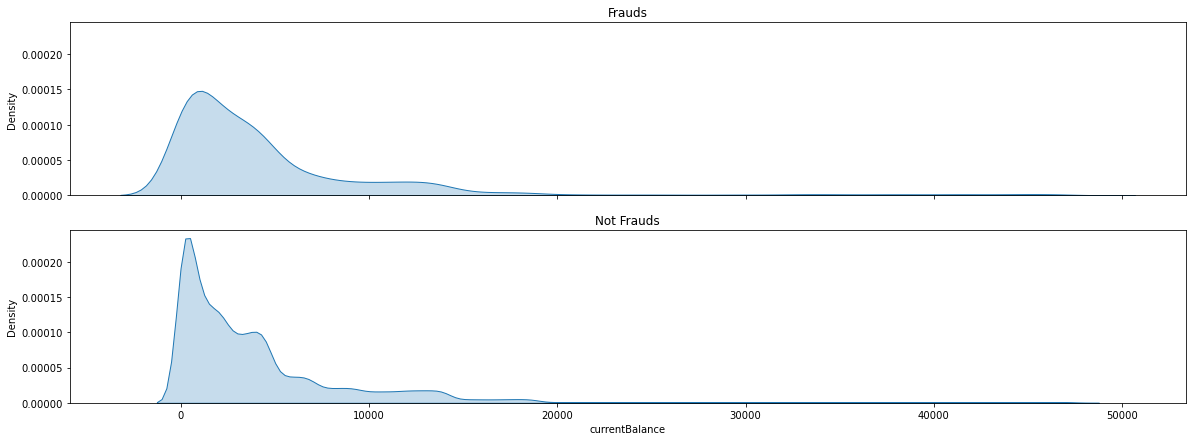

In [51]:
fig,ax = plt.subplots(2,1,sharex=True,sharey=True)
fig.set_figwidth(20)
fig.set_figheight(7)
sns.kdeplot(data = true, x = feature_columns[4],ax=ax[0],shade='fill',thresh=0.5)
ax[0].title.set_text('Frauds')
sns.kdeplot(data = false, x = feature_columns[4],ax=ax[1],shade='fill',thresh=0.5)
ax[1].title.set_text('Not Frauds')

we can see the as the density of the frauds are more when the current balance is negative or near to negative,

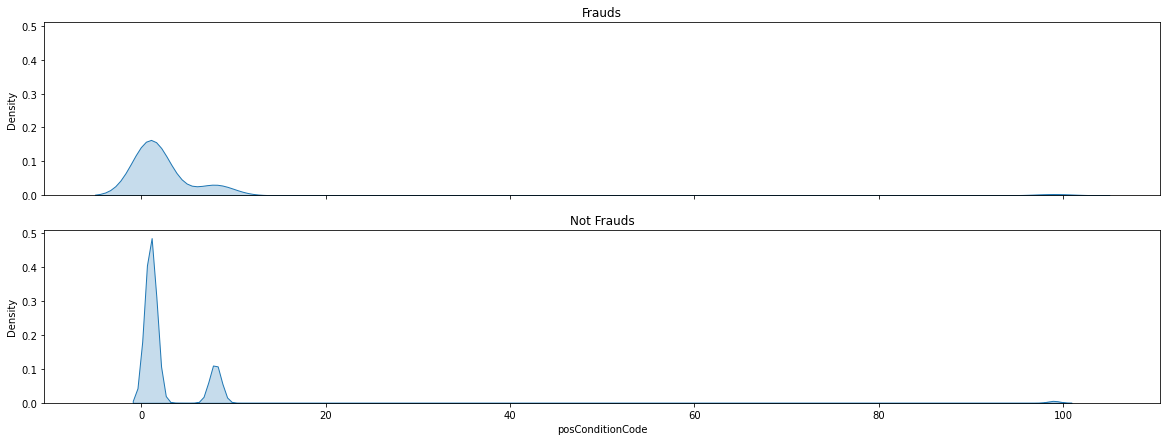

In [52]:
fig,ax = plt.subplots(2,1,sharex=True,sharey=True)
fig.set_figwidth(20)
fig.set_figheight(7)
sns.kdeplot(data = true, x = feature_columns[5],ax=ax[0],shade='fill',thresh=0.5)
ax[0].title.set_text('Frauds')
sns.kdeplot(data = false, x = feature_columns[5],ax=ax[1],shade='fill',thresh=0.5)
ax[1].title.set_text('Not Frauds')

the density of Frauds is more when the condition code is near 1, as we go further away the frauds decreses

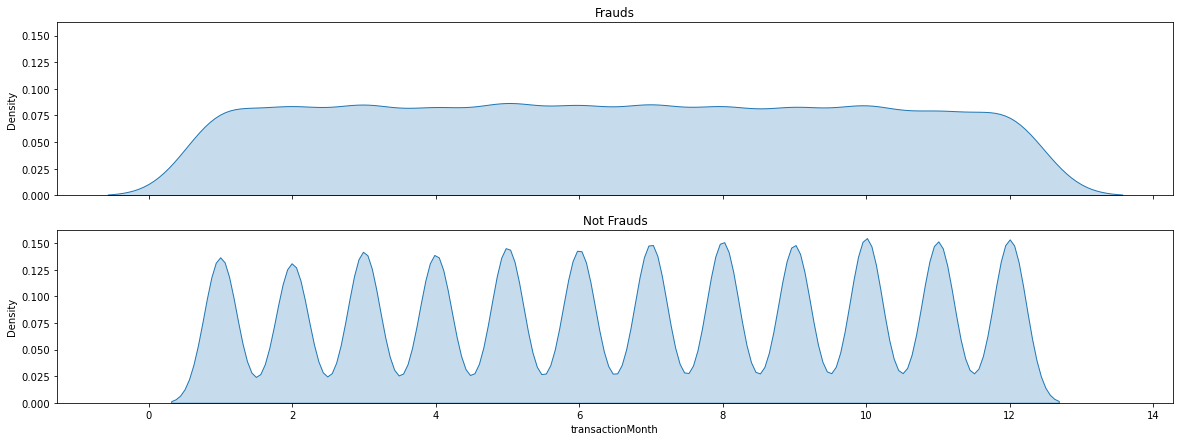

In [53]:
fig,ax = plt.subplots(2,1,sharex=True,sharey=True)
fig.set_figwidth(20)
fig.set_figheight(7)
sns.kdeplot(data = true, x = feature_columns[6],ax=ax[0],shade='fill',thresh=0.5)
ax[0].title.set_text('Frauds')
sns.kdeplot(data = false, x = feature_columns[6],ax=ax[1],shade='fill',thresh=0.5)
ax[1].title.set_text('Not Frauds')

we can see that the frauds are constant throught the months, but we can see non frauds transaction varies throughout the year

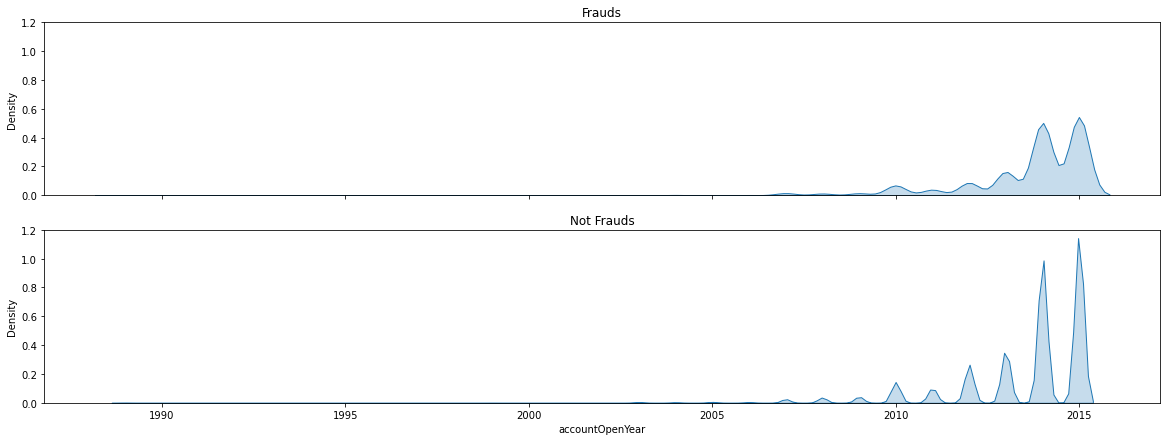

In [54]:
fig,ax = plt.subplots(2,1,sharex=True,sharey=True)
fig.set_figwidth(20)
fig.set_figheight(7)
sns.kdeplot(data = true, x = feature_columns[7],ax=ax[0],shade='fill',thresh=0.5)
ax[0].title.set_text('Frauds')
sns.kdeplot(data = false, x = feature_columns[7],ax=ax[1],shade='fill',thresh=0.5)
ax[1].title.set_text('Not Frauds')

Clearly, as the year increase most recent accounts will impact the fraud rate.

we can see the fraud rate is maximum for the year 2015 being most recent year.

###  preprocessing

In [55]:
feature_columns.extend(categorical_column)

In [56]:
feature_columns

['transactionAmount',
 'posEntryMode',
 'accountOpenMonth',
 'enteredCVV',
 'currentBalance',
 'posConditionCode',
 'transactionMonth',
 'accountOpenYear',
 'merchantName',
 'acqCountry',
 'merchantCountryCode',
 'merchantCategoryCode',
 'transactionType',
 'cardPresent']

In [57]:
y = df_copy['isFraud']
X = df_copy[feature_columns]

In [58]:
le = LabelEncoder()
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=206)
ms = MinMaxScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

In [59]:
ordinal_columns = categorical_column[:5]
onehot_columns = [categorical_column[5]]
numerical_column = list(set(feature_columns)-set(categorical_column))

In [60]:
transformer = ColumnTransformer(transformers=[('ordinal',oe,ordinal_columns),
                                             ('onehot',ohe,onehot_columns),
                                             ('scalar',ms,numerical_column)])

In [61]:
RUS=RandomUnderSampler(random_state=42)

### Modeling, Traning and Prediction

In [62]:
def transform_and_resample_data(X,y):
    """
    It accepts feature column and target column.
    split the data int train and test set in stratify manner.
    transform the target with label encoder
    over sample the target set.
    return train set and test set
    """
    
    train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    train_y = le.fit_transform(train_y)
    test_y = le.transform(test_y)
    train_X_resampled , train_y_resampled = RUS.fit_resample(train_X,train_y)


    return train_X_resampled,train_y_resampled,test_X,test_y



In [63]:
def prune_tree(train_X,train_y,transformer):
    """
    accepts the model and train data.
    fit to Decision tree return the required parameter. 
    
    It is used to prune the tree to generate range of the parameters.
    """
    model = DecisionTreeClassifier(criterion='gini',random_state=42)
    
    pipeline=Pipeline(steps=[('transform',transformer),
                             ('model',model)])
    
    pipeline.fit(train_X,train_y)
    return model.tree_.max_depth,model.tree_.n_features

In [64]:
def prune_forest(train_X,train_y,transformer):
    """
    accepts the model and train data.
    fit to Decision tree return the required parameter. 
    
    It is used to prune the tree to generate range of the parameters.
    """
    model = RandomForestClassifier(criterion='gini',random_state=42)
    
    pipeline=Pipeline(steps=[('transform',transformer),
                             ('model',model)])
    
    pipeline.fit(train_X,train_y)
    return model.n_estimators,model.max_depth

In [65]:
def model_selection(train_X,train_y,transformer,current=None):
    """
    It is used to select different models for traning purpose based in the value of current.
    
    """
    if current == 0:
        
        label='Logistic Regression'
        model = LogisticRegression(solver='liblinear')
        params = {'model__C':[0.001,0.01,0.1,1,10],
               'model__penalty':['l1','l2']}
        
    elif current == 1:
        
        label = 'KNeighborsClassifier'
        model = KNeighborsClassifier(weights='distance')
        params = {'model__n_neighbors':list(range(2,20))}
        
    elif current == 2:
        
        label = 'SVC'
        model = SVC(kernel='rbf')
        params = {'model__C':[0.001,0.01,0.1,1,10]}
        
    elif current == 3:
        
        label = 'DecisionTreeClassifier'
        model = DecisionTreeClassifier(criterion='entropy',random_state=42)
        max_depth, max_features = prune_tree(train_X,train_y,transformer)
        params = {'model__max_depth':list(range(1,max_depth+1,2)),
                 'model__max_features':list(range(1,max_features))}
    elif current == 4:
        label = 'RandomForestClassifier'
        model = RandomForestClassifier(criterion='entropy',random_state=42,warm_start=True)
        max_estimators,max_depth = prune_forest(train_X,train_y,transformer)
        params = {'model__n_estimators':list(range(1,max_estimators+1,50))}
        
    else:
        raise ValueError('No value passed for current')
        
    return model, params, label

In [66]:
def scoring(model , params, true, pred):
    """
    It is used to score the model based on its preformance 
    Accepts model , parameter, original labels and predicted labels
    
    """
    re_Y = recall_score(true, pred, pos_label=1)
    re_N = recall_score(true, pred, pos_label=0)
    pr_Y = precision_score(true, pred, pos_label=1)
    pr_N = precision_score(true, pred, pos_label=0)
    f1_Y = f1_score(true, pred, pos_label=1)
    f1_N = f1_score(true, pred, pos_label=0)
    acc = accuracy_score(true, pred)
    data = pd.Series({'model':model,
                      'params': params,
                      'recall_Yes': re_Y,
                      'recall_No': re_N,
                      'precision_Yes':pr_Y,
                      'precision_No':pr_N,
                      'f1_Yes':f1_Y,
                      'f1_No':f1_N,
                      'accuracy':acc})
    
    return data

In [67]:
performance =  pd.DataFrame(columns=['model','params','recall_Yes','recall_No','precision_Yes','precision_No','f1_Yes','f1_No','accuracy'])

#get train and test set
train_X,train_y,test_X,test_y = transform_and_resample_data(X,y)

#call different model fir training and testing
for i in range(5):
    
    model, param, label = model_selection(train_X, train_y, transformer, current=i)
    pipeline = Pipeline(steps = [('transform',transformer),
                             ('model',model)])
    
    #score metric 
    score = {'r':'recall','p':'precision'} 
    grid = GridSearchCV(pipeline,param,cv=4,scoring=score, refit='r')
    
    grid.fit(train_X,train_y)
    
    pred = grid.predict(test_X)
    
    para = grid.best_estimator_.named_steps['model']
    
    performance = performance.append(scoring(label, para, test_y, pred),ignore_index=True)

    string = 'This results are for '+label
    print(19*'* '+string+19*' *')
    print('----- Classification report -----')
    print(classification_report(test_y,pred))
    print('----- Confusion matrix -----')
    print(confusion_matrix(test_y,pred))

* * * * * * * * * * * * * * * * * * * This results are for Logistic Regression * * * * * * * * * * * * * * * * * * *
----- Classification report -----
              precision    recall  f1-score   support

           0       0.99      0.39      0.56    154790
           1       0.02      0.68      0.03      2483

    accuracy                           0.39    157273
   macro avg       0.50      0.54      0.30    157273
weighted avg       0.97      0.39      0.55    157273

----- Confusion matrix -----
[[60149 94641]
 [  788  1695]]
* * * * * * * * * * * * * * * * * * * This results are for KNeighborsClassifier * * * * * * * * * * * * * * * * * * *
----- Classification report -----
              precision    recall  f1-score   support

           0       0.99      0.65      0.79    154790
           1       0.03      0.72      0.06      2483

    accuracy                           0.65    157273
   macro avg       0.51      0.69      0.42    157273
weighted avg       0.98      0.65     

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* * * * * * * * * * * * * * * * * * * This results are for SVC * * * * * * * * * * * * * * * * * * *
----- Classification report -----
              precision    recall  f1-score   support

           0       0.99      0.49      0.66    154790
           1       0.02      0.66      0.04      2483

    accuracy                           0.49    157273
   macro avg       0.50      0.57      0.35    157273
weighted avg       0.97      0.49      0.65    157273

----- Confusion matrix -----
[[76147 78643]
 [  855  1628]]
* * * * * * * * * * * * * * * * * * * This results are for DecisionTreeClassifier * * * * * * * * * * * * * * * * * * *
----- Classification report -----
              precision    recall  f1-score   support

           0       0.99      0.26      0.41    154790
           1       0.02      0.79      0.03      2483

    accuracy                           0.26    157273
   macro avg       0.50      0.52      0.22    157273
weighted avg       0.97      0.26      0.40    15727

In [68]:
performance

,model,params,recall_Yes,recall_No,precision_Yes,precision_No,f1_Yes,f1_No,accuracy
0,Logistic Regression,"LogisticRegression(C=0.001, penalty='l1', solv...",0.682642,0.388585,0.017595,0.987069,0.034305,0.557640,0.393227
1,KNeighborsClassifier,"KNeighborsClassifier(n_neighbors=19, weights='...",0.720097,0.652129,0.032138,0.993162,0.061530,0.787301,0.653202
2,SVC,SVC(C=1),0.655658,0.491937,0.020281,0.988896,0.039346,0.657029,0.494522
3,DecisionTreeClassifier,"DecisionTreeClassifier(criterion='entropy', ma...",0.790173,0.256315,0.016758,0.987039,0.032820,0.406952,0.264743
4,RandomForestClassifier,"(DecisionTreeClassifier(criterion='entropy', m...",0.745872,0.749622,0.045607,0.994591,0.085958,0.854904,0.749563


In [69]:
v1,v2,v3,v4,v5 = performance['params']

In [70]:
estimator=[('kn',v2),('dt',v4),('rf',v5)]

In [71]:
vote = VotingClassifier(estimators=estimator)

In [72]:
pipeline = Pipeline(steps = [('transform',transformer),
                             ('model',vote)])

score = {'r':'recall','p':'precision'} 
pipeline.fit(train_X,train_y)
   
pred = pipeline.predict(test_X)
    
print(classification_report(test_y,pred))

              precision    recall  f1-score   support

           0       0.99      0.63      0.77    154790
           1       0.03      0.79      0.06      2483

    accuracy                           0.63    157273
   macro avg       0.51      0.71      0.42    157273
weighted avg       0.98      0.63      0.76    157273



Since our aim is to build a predictive model we opt for the model with best precision, and accuracy.

Choosing only the accuracy as the parameter can be influenced by the negative class.

We can see clearly the model RandomForestClassifier is best of the rest gaining high recall, accuracy and precision for both negative and positive class.